In [1]:
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras

In [2]:
path_images = "/kaggle/input/brain-images/NEW" 
SEED = 42 # Seed to ensure data reproducibility
IMG_SIZE = (128, 128) # Size of images
BATCH_SIZE = 16 # Batch size
class_names=['yes', 'no']
AUTO = tf.data.AUTOTUNE # Autotuning for parallelization




train_ds = tf.keras.utils.image_dataset_from_directory(
    path_images,
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_names=class_names
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    path_images,
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_names=class_names
)

# Add `.repeat()` to ensure the dataset never runs out of data
# train_ds = train_ds.repeat()  # Repeats indefinitely
# val_ds = val_ds.repeat()

# Prefetch for performance
train_ds = train_ds.prefetch(buffer_size=AUTO)
val_ds = val_ds.prefetch(buffer_size=AUTO)


num_train_samples = 1003  # Total training samples
num_val_samples = 250    # Total validation samples

# VALIDATION_STEPS = num_val_samples // BATCH_SIZE

# Add `.repeat()` for infinite data cycling and prefetch for performance
# train_dataset = train_dataset.repeat().prefetch(buffer_size=AUTO)
# validation_dataset = validation_dataset.repeat().prefetch(buffer_size=AUTO)

Found 1253 files belonging to 2 classes.
Using 1003 files for training.
Found 1253 files belonging to 2 classes.
Using 250 files for validation.


In [3]:
NUM_CLASSES = 2 # Number of classes in the dataset (tumor and non-tumor)
# STEPS_PER_EPOCH = 10 # Number of steps per epoch during training
# STEPS_PER_EPOCH = len(train_ds) // BATCH_SIZE
STEPS_PER_EPOCH = num_train_samples // BATCH_SIZE

# VALIDATION_STEPS = len(validation_dataset) // BATCH_SIZE
SCHEDULE_LENGTH = 500 # Length of the training schedule (number of batches to be processed) processed)
SCHEDULE_BOUNDARIES = [200, 300, 400] # the larger the dataset size, the longer the schedule lengtha

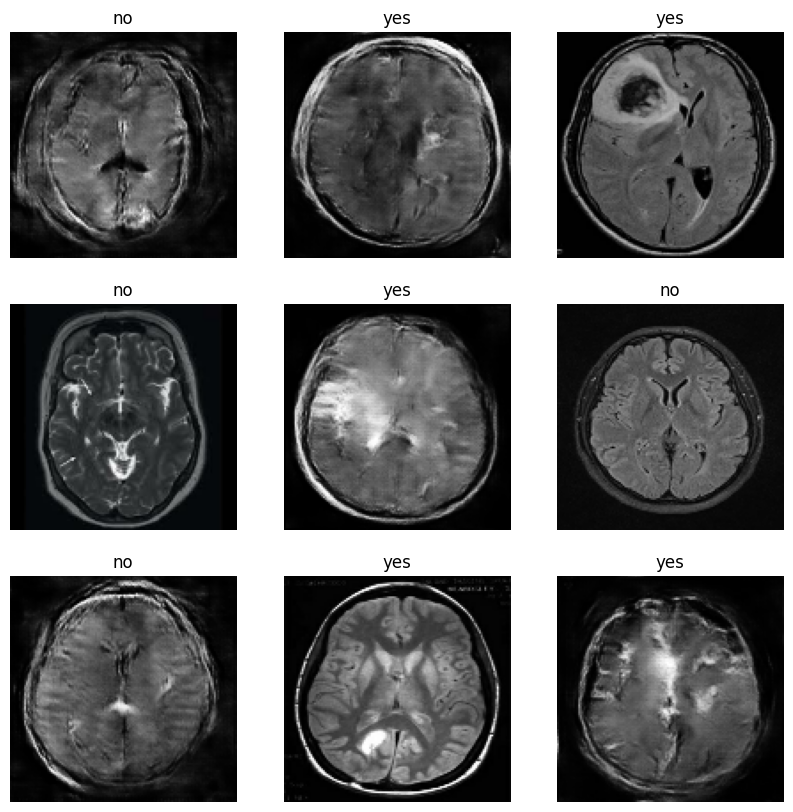

In [4]:
# class_names = train_ds.class_names
# plt.figure(figsize=(10, 10))
# for images, labels in train_ds.take(1):
#       for i in range(9):
#         ax = plt.subplot(3, 3, i + 1)
#         plt.imshow(images[i].numpy().astype("uint8"))
#         plt.title(class_names[labels[i]])
#         plt.axis("off")

# Ensure train_ds is not repeated for visualization
train_ds_visual = train_ds.take(1)  # Take a single batch for visualization

# Visualize 9 images from the dataset
plt.figure(figsize=(10, 10))
for images, labels in train_ds_visual:
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        # Convert labels to integers if they are one-hot encoded
        if len(labels[i].shape) > 0:  # Check if it's one-hot encoded
            label_index = tf.argmax(labels[i]).numpy()
        else:
            label_index = labels[i].numpy()
        
        plt.title(class_names[label_index])
        plt.axis("off")


In [5]:
bit_model_url = "https://tfhub.dev/google/bit/m-r50x1/1"
bit_module = hub.load(bit_model_url)

In [6]:
class MyBiTModel(keras.Model):
    def __init__(self, num_classes, module, **kwargs):
        super().__init__(**kwargs)

        self.num_classes = num_classes
        self.head = keras.layers.Dense(num_classes, kernel_initializer="zeros")
        self.bit_model = module

    def call(self, images):
        bit_embedding = self.bit_model(images)
        return self.head(bit_embedding)

In [7]:
model = MyBiTModel(num_classes=NUM_CLASSES, module=bit_module)
learning_rate = 0.003 * BATCH_SIZE / 512

# Decay learning rate by a factor of 10 at SCHEDULE_BOUNDARIES.
lr_schedule = keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=SCHEDULE_BOUNDARIES,
    values=[
        learning_rate,
        learning_rate * 0.1,
        learning_rate * 0.01,
        learning_rate * 0.001,
    ],
)
optimizer = keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)

loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model.compile(optimizer=optimizer, loss=loss_fn, metrics=["accuracy"], jit_compile=False)

In [8]:
train_callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_accuracy", patience=2, restore_best_weights=True
    )
]

In [9]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    # epochs=int(SCHEDULE_LENGTH / STEPS_PER_EPOCH),
    epochs=10,
    # steps_per_epoch=STEPS_PER_EPOCH,
    # steps_per_epoch=60,
    validation_data=val_ds,
    # callbacks=train_callbacks,
)

Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 81ms/step - accuracy: 0.7515 - loss: 0.4850 - val_accuracy: 0.9520 - val_loss: 0.1567
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.9405 - loss: 0.1636 - val_accuracy: 0.9200 - val_loss: 0.2012
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.9551 - loss: 0.1316 - val_accuracy: 0.9680 - val_loss: 0.1226
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.9658 - loss: 0.1059 - val_accuracy: 0.9640 - val_loss: 0.1025
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.9699 - loss: 0.0954 - val_accuracy: 0.9640 - val_loss: 0.1007
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.9698 - loss: 0.0973 - val_accuracy: 0.9640 - val_loss: 0.1013
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.9659 - loss: 0.0971 - val_accuracy: 0.9640 - val_loss: 0.1018
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.9685 - loss: 0.0930 - val_accuracy: 0.9640 - 

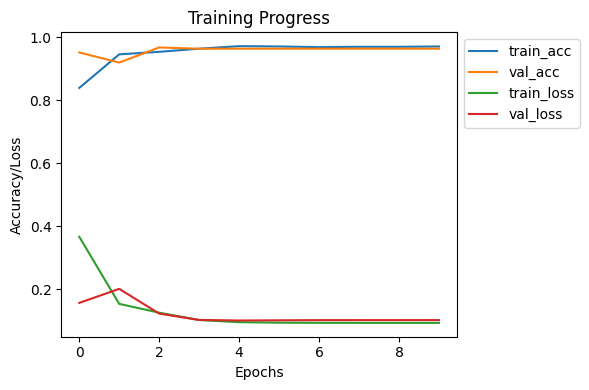

In [10]:
# def plot_hist(hist):
#     plt.plot(hist.history["accuracy"])
#     plt.plot(hist.history["val_accuracy"])
#     plt.plot(hist.history["loss"])
#     plt.plot(hist.history["val_loss"])
#     plt.title("Training Progress")
#     plt.ylabel("Accuracy/Loss")
#     plt.xlabel("Epochs")
#     plt.legend(["train_acc", "val_acc", "train_loss", "val_loss"], loc="upper left")
#     plt.show()


# plot_hist(history)

def plot_hist(hist):
    plt.figure(figsize=(6, 4))  # Optional: Adjust the figure size
    plt.plot(hist.history["accuracy"], label="train_acc")
    plt.plot(hist.history["val_accuracy"], label="val_acc")
    plt.plot(hist.history["loss"], label="train_loss")
    plt.plot(hist.history["val_loss"], label="val_loss")
    
    plt.title("Training Progress")
    plt.ylabel("Accuracy/Loss")
    plt.xlabel("Epochs")
    
    # Place legend outside the graph
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
    plt.tight_layout()  # Adjust layout to fit the legend outside
    plt.show()

# Call the function with your training history
plot_hist(history)
